In [8]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
from io import StringIO
import sys

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:

# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])



In [3]:

# Dataset and Creating Train/Test Split

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)



In [6]:
# Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


In [5]:
raw_train_data = train.data  

In [10]:
raw_train_data.max(), raw_train_data.min(), raw_train_data.mean()

(np.uint8(255), np.uint8(0), np.float64(120.70756512369792))

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# Convert to PyTorch tensor first, then scale
raw_train_data = train.data  
float_data = torch.tensor(raw_train_data, dtype=torch.float32) / 255.0

print('[Train]')
print(' - Numpy Shape:', raw_train_data.shape)
print(' - Tensor Shape:', float_data.size())
print(' - min:', torch.min(float_data))
print(' - max:', torch.max(float_data))
print(' - mean:', torch.mean(float_data))
print(' - std:', torch.std(float_data))
print(' - var:', torch.var(float_data))


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.4734)
 - std: tensor(0.2516)
 - var: tensor(0.0633)


torch.Size([128, 3, 32, 32])
torch.Size([128])


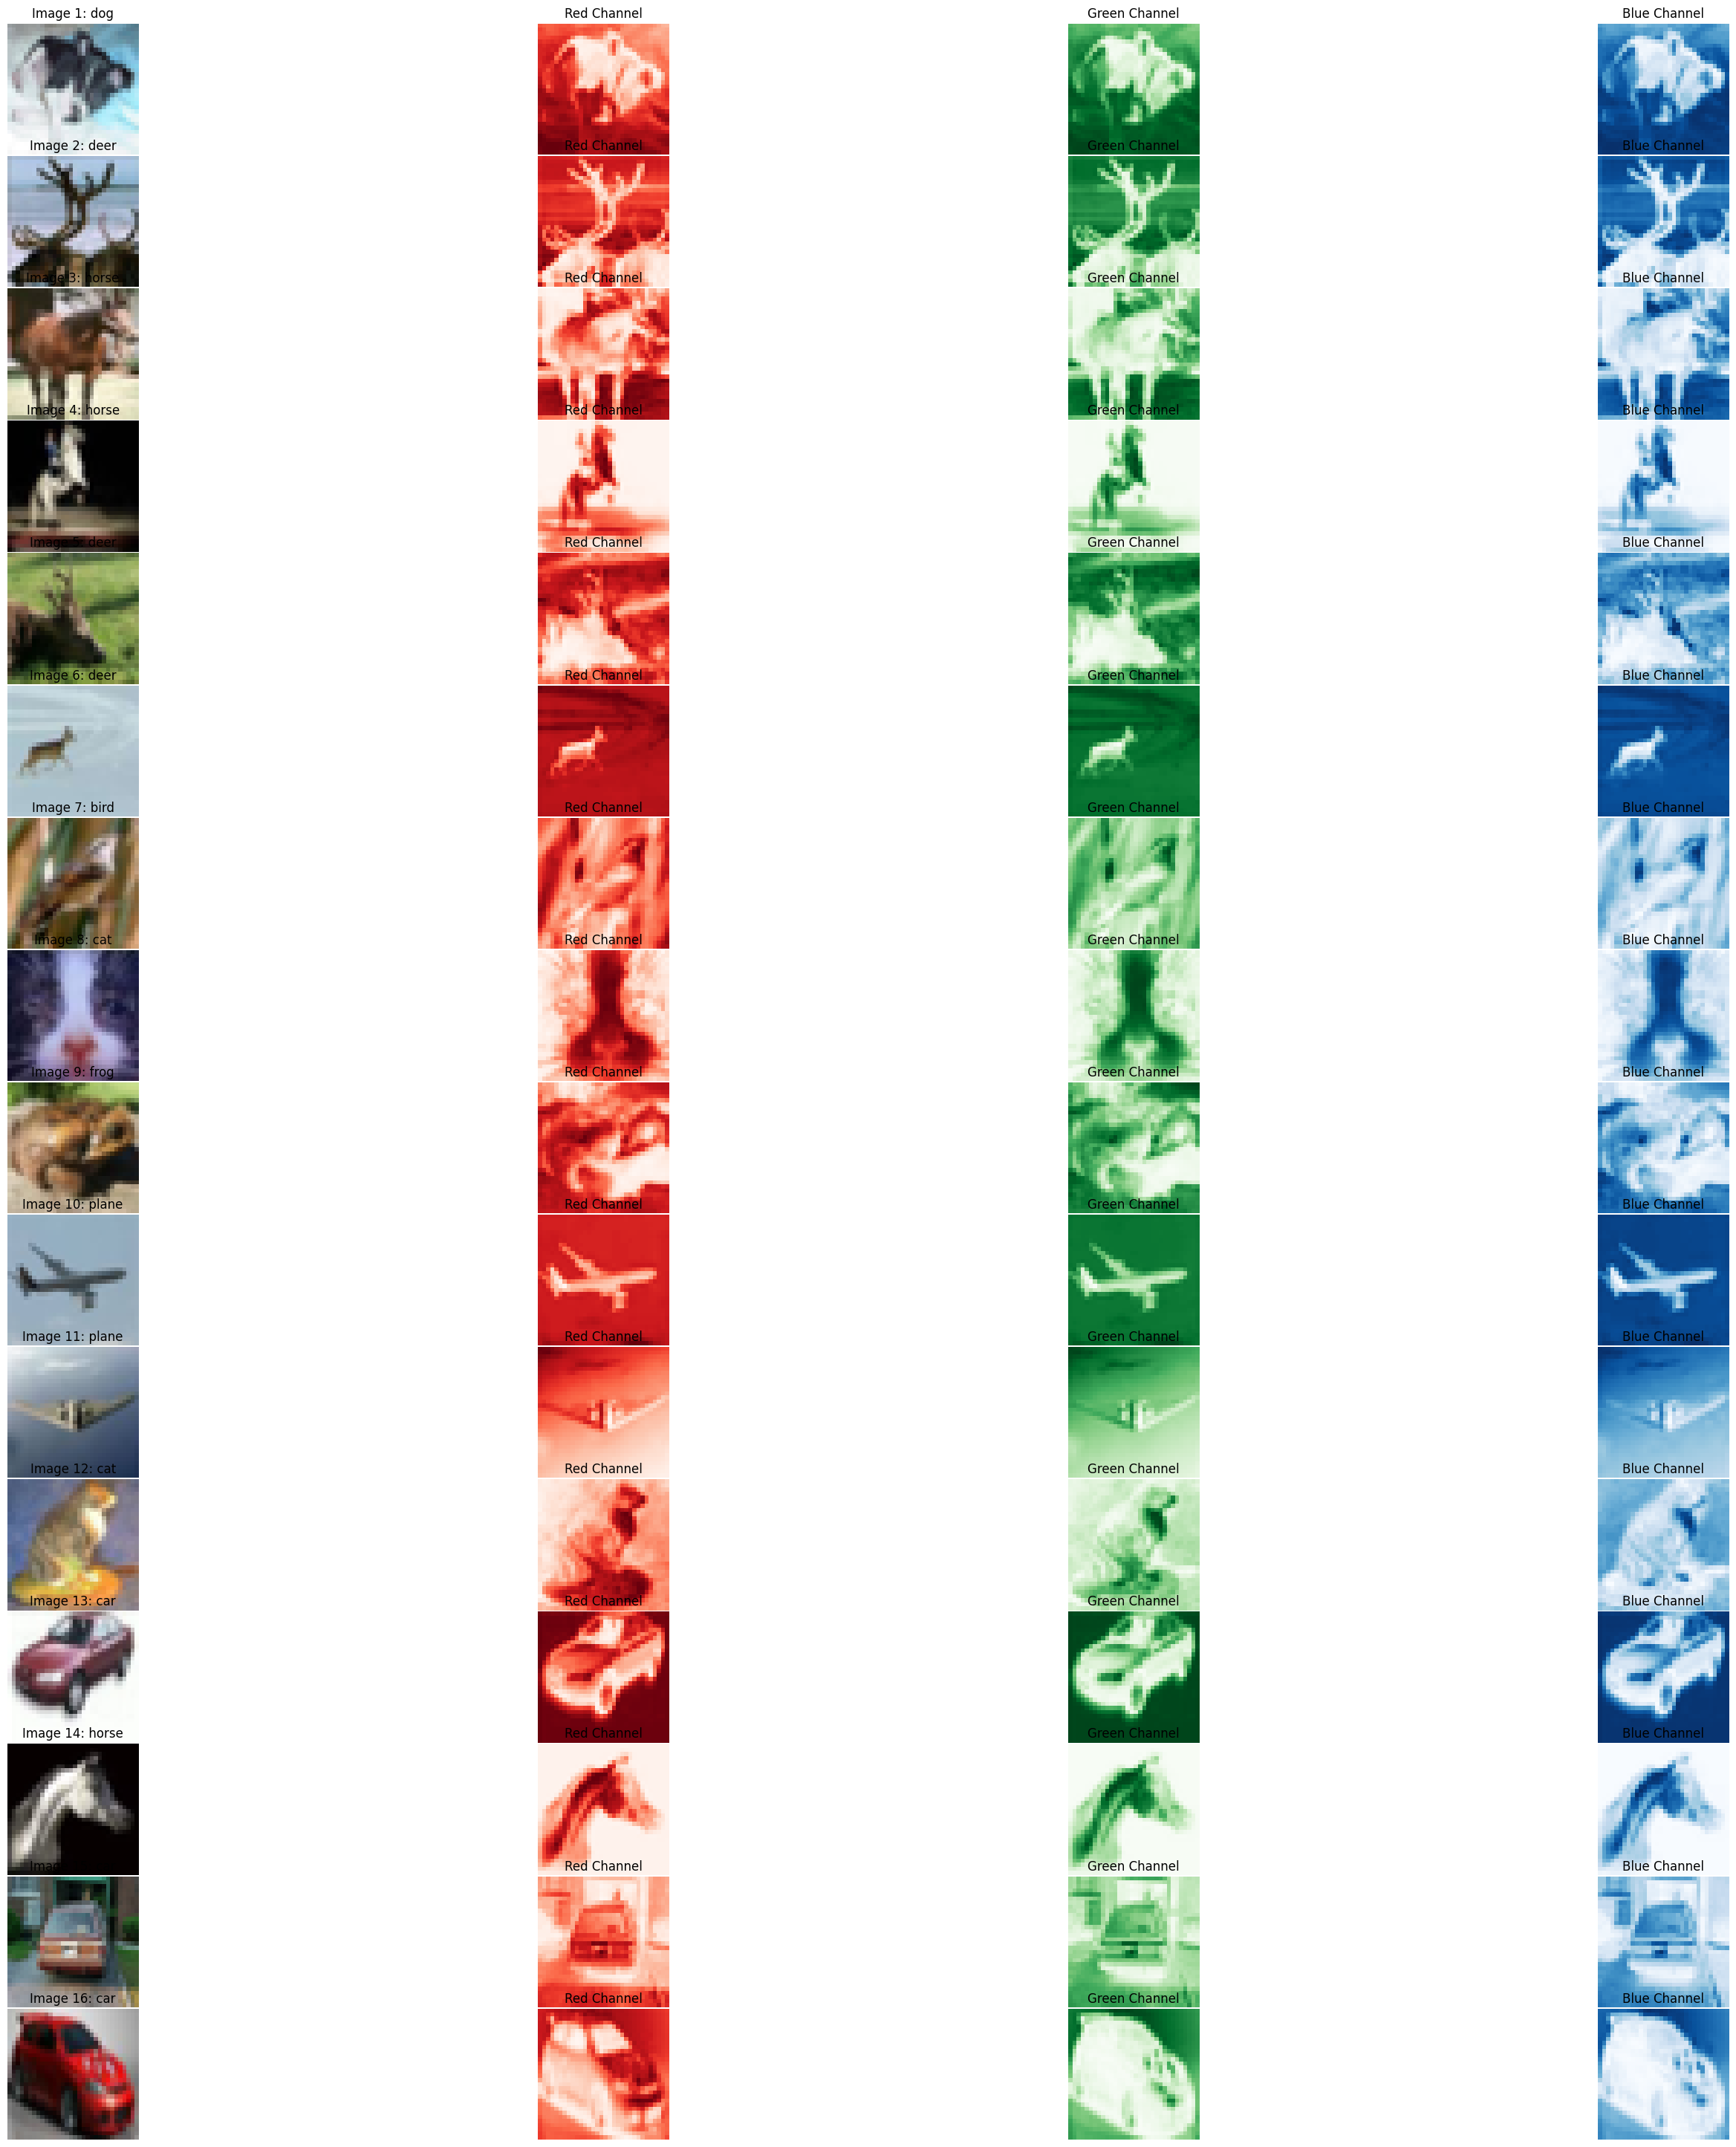

In [60]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(images.shape)
print(labels.shape)

# Create a 4x4 grid of images
fig, axes = plt.subplots(16, 4, figsize=(32, 32))  # Reduced width

for i in range(16):
    img = images[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    # axes[i].imshow(img)
    # axes[i].set_title(f'{classes[labels[i]]}')
    # axes[i].axis('off')

     # Original RGB image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Image {i+1}: {classes[labels[i]]}')
    axes[i, 0].axis('off')
    
    # Red channel
    axes[i, 1].imshow(img[:,:,0], cmap='Reds')
    axes[i, 1].set_title(f'Red Channel')
    axes[i, 1].axis('off')
    
    # Green channel
    axes[i, 2].imshow(img[:,:,1], cmap='Greens')
    axes[i, 2].set_title(f'Green Channel')
    axes[i, 2].axis('off')
    
    # Blue channel
    axes[i, 3].imshow(img[:,:,2], cmap='Blues')
    axes[i, 3].set_title(f'Blue Channel')
    axes[i, 3].axis('off')
    

plt.subplots_adjust(left=0.1, right=0.99, top=0.99, bottom=0.1, 
                    wspace=0.01, hspace=0.01)
plt.show()